# Notebook to generate realistic masks on already lesioned images

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import itertools
import numpy as np
import pandas as pd
import pulp
import shutil
import ants
from PIL import Image

### Count the subject IDs in the test folder

In [2]:
def count_and_list_middle_numbers(directory, dataset_name):
    """
    Count and list the distinct subject IDs (middle numbers) for a given dataset.

    Args:
        directory (str): Directory containing the .png files.
        dataset_name (str): One of ['VH', 'WMH2017', 'SHIFTS'].

    Returns:
        int: Number of distinct subject IDs.
    """
    middle_numbers = set()

    for filename in os.listdir(directory):
        if not filename.endswith(".png"):
            continue

        if dataset_name in ['VH', 'WMH2017'] and filename.startswith(dataset_name + "_"):
            parts = filename.split('_')
            if len(parts) >= 3:
                middle_numbers.add(int(parts[1]))

        elif dataset_name == 'SHIFTS':
            if filename.startswith('train_'):
                parts = filename.split('_')
                if len(parts) >= 3:
                    middle_numbers.add(parts[0]+parts[1])
            elif filename.startswith(('dev_in', 'eval_in', 'dev_out')):
                parts = filename.split('_')
                if len(parts) >= 4:
                    middle_numbers.add(parts[0]+parts[1]+parts[2])

    sorted_ids = sorted(middle_numbers)
    print(f"{dataset_name}: {len(sorted_ids)} distinct subject IDs")
    print("Subject IDs:", ', '.join(map(str, sorted_ids)))
    
    # return len(sorted_ids)


In [3]:
directory = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/flair"

count_and_list_middle_numbers(directory, 'VH')
count_and_list_middle_numbers(directory, 'WMH2017')
count_and_list_middle_numbers(directory, 'SHIFTS')

directory = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/mask"
count_and_list_middle_numbers(directory, 'VH')
count_and_list_middle_numbers(directory, 'WMH2017')
count_and_list_middle_numbers(directory, 'SHIFTS')

VH: 18 distinct subject IDs
Subject IDs: 648, 727, 728, 729, 738, 739, 741, 743, 744, 745, 746, 747, 749, 751, 752, 754, 755, 758
WMH2017: 18 distinct subject IDs
Subject IDs: 6, 27, 29, 31, 33, 37, 39, 49, 50, 56, 58, 59, 65, 101, 103, 126, 132, 137
SHIFTS: 30 distinct subject IDs
Subject IDs: devin2, devin4, devin6, devout14, devout18, devout20, devout21, devout22, devout24, devout25, devout8, evalin10, evalin18, evalin19, evalin21, evalin25, evalin30, evalin33, evalin4, evalin5, evalin9, train14, train19, train22, train23, train28, train3, train32, train4, train6
VH: 18 distinct subject IDs
Subject IDs: 648, 727, 728, 729, 738, 739, 741, 743, 744, 745, 746, 747, 749, 751, 752, 754, 755, 758
WMH2017: 18 distinct subject IDs
Subject IDs: 6, 27, 29, 31, 33, 37, 39, 49, 50, 56, 58, 59, 65, 101, 103, 126, 132, 137
SHIFTS: 30 distinct subject IDs
Subject IDs: devin2, devin4, devin6, devout14, devout18, devout20, devout21, devout22, devout24, devout25, devout8, evalin10, evalin18, evalin19

### Select and save the test images that will be used with their masks (created)

1. Create a table of area of masks for each subject and slice
2. Select one image per dataset and slice of different subjects so that the total area is minimal (this way we select the helthier images)
3. Save the selected images and their masks in a new folder
4. Segment the selected images into WM/GM/CSF
5. Create the masks for this new images based on masks from other images in the same slice and that they are not in the CSF/GM areas

In [4]:
def build_area_table(directory, dataset_name):
    """
    Builds a table with rows as subject IDs, columns as slice numbers, and values as white pixel area.

    Args:
        directory (str): Path to the folder containing mask .png files.
        dataset_name (str): One of ['VH', 'WMH2017', 'SHIFTS'].

    Returns:
        pd.DataFrame: Table of area values per subject and slice.
    """
    table = {}

    for filename in os.listdir(directory):
        if not filename.endswith(".png"):
            continue

        if dataset_name in ['VH', 'WMH2017'] and filename.startswith(dataset_name + "_"):
            parts = filename.split('_')
            if len(parts) >= 3:
                subject_id = int(parts[1])
                slice_id = int(parts[2].replace(".png", ""))
        elif dataset_name == 'SHIFTS':
            parts = filename.split('_')
            if filename.startswith('train_') and len(parts) >= 3:
                subject_id = parts[0] + '_' + parts[1]
                slice_id = int(parts[2].replace(".png", ""))
            elif filename.startswith(('dev_in', 'eval_in', 'dev_out')) and len(parts) >= 4:
                subject_id = parts[0] + '_' + parts[1] + '_' + parts[2]
                slice_id = int(parts[3].replace(".png", ""))
            else:
                continue
        else:
            continue

        # Load mask image in grayscale
        image_path = os.path.join(directory, filename)
        mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print(f"Warning: could not read image {filename}")
            continue

        # Compute white pixel area (assuming white is 255)
        # white_area = np.sum(mask == 255)
        white_area = np.sum(mask > 0)

        # Store in table
        if subject_id not in table:
            table[subject_id] = {}
        table[subject_id][slice_id] = white_area

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(table, orient='index').sort_index(axis=0).sort_index(axis=1)
    df.index.name = 'Subject ID'
    df.columns.name = 'Slice Number'
    
    return df


def find_min_area_combination(df):
    """
    Select one value per column (slice) from different rows (subjects) to minimize total area.

    Args:
        df (pd.DataFrame): Rows are subjects, columns are slices, values are areas.

    Returns:
        tuple: (min_area, selected_subjects_dict) where keys are slice IDs and values are subject IDs.
    """
    slice_ids = df.columns.tolist()
    subject_ids = df.index.tolist()

    # Filter subjects that have all 13 slices
    valid_subjects = [s for s in subject_ids if df.loc[s].count() == len(slice_ids)]

    if len(valid_subjects) < len(slice_ids):
        raise ValueError("Not enough subjects with all slices to perform selection.")

    # Create a list of candidate subjects for each slice
    candidates = {slice_id: df[slice_id].dropna().sort_values().index.tolist()
                  for slice_id in slice_ids}

    # Brute-force all combinations of subjects (one per slice)
    best_total = float('inf')
    best_combo = None

    for combo in itertools.permutations(df.index, r=len(slice_ids)):
        if len(set(combo)) != len(slice_ids):
            continue  # Skip if subject appears more than once

        total = 0
        valid = True
        for i, subject in enumerate(combo):
            area = df.iloc[df.index.get_loc(subject), i]
            if pd.isna(area):
                valid = False
                break
            total += area

        if valid and total < best_total:
            best_total = total
            best_combo = {slice_ids[i]: combo[i] for i in range(len(slice_ids))}

    return best_total, best_combo


def solve_min_area_ilp(df):
    """
    Solve the minimal-area mask combination problem using ILP.

    Args:
        df (pd.DataFrame): Rows = subject IDs, Columns = slice IDs, Values = areas.

    Returns:
        tuple: (total_area, {slice_id: subject_id})
    """
    df = df.dropna()  # Ensure no NaNs
    subjects = df.index.tolist()
    slices = df.columns.tolist()

    # Define problem
    prob = pulp.LpProblem("Minimize_Total_Mask_Area", pulp.LpMinimize)

    # Define binary decision variables: x[s, sl] = 1 if subject s is chosen for slice sl
    x = pulp.LpVariable.dicts("x", ((s, sl) for s in subjects for sl in slices), cat='Binary')

    # Objective: minimize total area
    prob += pulp.lpSum(x[s, sl] * df.at[s, sl] for s in subjects for sl in slices)

    # Constraint: exactly one subject selected per slice
    for sl in slices:
        prob += pulp.lpSum(x[s, sl] for s in subjects) == 1

    # Constraint: each subject can only be used once (across all slices)
    for s in subjects:
        prob += pulp.lpSum(x[s, sl] for sl in slices) <= 1

    # Solve
    solver = pulp.PULP_CBC_CMD(msg=False)
    prob.solve(solver)

    # Extract solution
    selected = {sl: s for s in subjects for sl in slices if pulp.value(x[s, sl]) == 1}
    total_area = sum(df.at[s, sl] for sl, s in selected.items())

    return total_area, selected

def copy_selected_masks(df, selected, dataset_name, src_dir, dst_dir):
    """
    Copy selected mask files based on the subject-slice mapping into a new folder.

    Args:
        df (pd.DataFrame): Area DataFrame (subject × slice).
        selected (dict): Mapping {slice_id: subject_id}.
        dataset_name (str): One of ['VH', 'WMH2017', 'SHIFTS'].
        src_dir (str): Path to the folder containing original mask .png files.
        dst_dir (str): Destination directory for selected masks.
    """
    os.makedirs(dst_dir, exist_ok=True)

    for slice_id, subject_id in selected.items():
        filename = None

        if dataset_name in ['VH', 'WMH2017']:
            # Reconstruct filename: e.g., VH_648_5.png
            filename = f"{dataset_name}_{subject_id}_{slice_id}.png"

        elif dataset_name == 'SHIFTS':
            # Subject IDs are strings like 'train14' or 'eval_in2512'
            if subject_id.startswith('train_'):
                subject_num = subject_id.replace('train_', '')
                filename = f"train_{subject_num}_{slice_id}.png"
            elif subject_id.startswith('dev_in_'):
                nums = subject_id.replace('dev_in_', '')
                filename = f"dev_in_{nums}_{slice_id}.png"
            elif subject_id.startswith('eval_in_'):
                nums = subject_id.replace('eval_in_', '')
                filename = f"eval_in_{nums}_{slice_id}.png"
            elif subject_id.startswith('dev_out_'):
                nums = subject_id.replace('dev_out_', '')
                filename = f"dev_out_{nums}_{slice_id}.png"

        if filename is None:
            print(f"Warning: could not reconstruct filename for subject {subject_id}, slice {slice_id}")
            continue

        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)

        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"File not found: {src_path}")

def segment_flair_folder(dst_dir_flair):
    # Output folders in ./test_images
    base_dir = os.path.dirname(dst_dir_flair.rstrip("/"))
    bkgnd_dir = os.path.join(base_dir, "BKGND")
    csf_dir = os.path.join(base_dir, "CSF")
    # wm_dir = os.path.join(base_dir, "WM")
    # gm_dir = os.path.join(base_dir, "GM")
    wm_gm_dir = os.path.join(base_dir, "WM_GM")
    os.makedirs(bkgnd_dir, exist_ok=True)
    os.makedirs(csf_dir, exist_ok=True)
    # os.makedirs(wm_dir, exist_ok=True)
    # os.makedirs(gm_dir, exist_ok=True)
    os.makedirs(wm_gm_dir, exist_ok=True)

    png_files = [f for f in os.listdir(dst_dir_flair) if f.endswith(".png") and os.path.isfile(os.path.join(dst_dir_flair, f))]

    for filename in png_files:
        path = os.path.join(dst_dir_flair, filename)
        arr = np.array(Image.open(path).convert("L")).astype(np.float32)

        # Create ANTs image
        img = ants.from_numpy(arr)
        mask = ants.get_mask(img)

        # Run Atropos
        seg = ants.atropos(
            a=img,
            m='[0.2,1x1]',
            c='[2,0]',
            i='kmeans[3]',
            x=mask,
            verbose=0
        )

        # Get segmentation labels
        seg_image = seg["segmentation"]
        unique_labels = np.unique(seg_image.numpy())
        means = [img.numpy()[seg_image.numpy() == l].mean() for l in unique_labels]
        sorted_labels = np.argsort(means)

        # Assign labels based on sorted means
        bkgnd_label = unique_labels[sorted_labels[0]]
        csf_label = unique_labels[sorted_labels[1]]
        wm_label  = unique_labels[sorted_labels[2]]
        gm_label  = unique_labels[sorted_labels[3]]

        # Create masks
        bkgnd_mask = (seg_image == bkgnd_label).numpy().astype(np.uint8) * 255
        csf_mask = (seg_image == csf_label).numpy().astype(np.uint8) * 255
        # wm_mask = (seg_image == wm_label).numpy().astype(np.uint8) * 255
        # gm_mask = (seg_image == gm_label).numpy().astype(np.uint8) * 255
        wm_gm_mask = (seg_image == wm_label).numpy().astype(np.uint8) * 255 + (seg_image == gm_label).numpy().astype(np.uint8) * 255

        # Save masks
        Image.fromarray(bkgnd_mask).save(os.path.join(bkgnd_dir, filename))
        Image.fromarray(csf_mask).save(os.path.join(csf_dir, filename))
        # Image.fromarray(wm_mask).save(os.path.join(wm_dir, filename))
        # Image.fromarray(gm_mask).save(os.path.join(gm_dir, filename))
        Image.fromarray(wm_gm_mask).save(os.path.join(wm_gm_dir, filename))

        print(f"Segmented and saved: {filename}")


#### 1

In [5]:
directory = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/mask"

df_vh = build_area_table(directory, 'VH')
df_wmh = build_area_table(directory, 'WMH2017')
df_shifts = build_area_table(directory, 'SHIFTS')

# # Save to CSV or display
# df_vh.to_csv("vh_mask_area_table.csv")
# print(df_vh.head())


#### 2, 3

In [6]:
total_area_vh, best_combo_vh = solve_min_area_ilp(df_vh)

print("Minimum total area:", total_area_vh)
print("Selected subjects per slice:")
for sl in sorted(best_combo_vh):
    print(f"Slice {sl}: Subject {best_combo_vh[sl]}")

src_dir_mask = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/mask"
src_dir_flair = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/flair"
dst_dir_mask = "./test_images/mask"
dst_dir_flair = "./test_images/flair"
copy_selected_masks(df_vh, best_combo_vh, 'VH', src_dir_mask, dst_dir_mask)
copy_selected_masks(df_vh, best_combo_vh, 'VH', src_dir_flair, dst_dir_flair)


Minimum total area: 67
Selected subjects per slice:
Slice 0: Subject 648
Slice 1: Subject 741
Slice 2: Subject 729
Slice 3: Subject 739
Slice 4: Subject 745
Slice 5: Subject 746
Slice 6: Subject 749
Slice 7: Subject 738
Slice 8: Subject 727
Slice 9: Subject 751
Slice 10: Subject 752
Slice 11: Subject 754
Slice 12: Subject 758


In [7]:
total_area_wmh, best_combo_wmh = solve_min_area_ilp(df_wmh)

print("Minimum total area:", total_area_wmh)
print("Selected subjects per slice:")
for sl in sorted(best_combo_wmh):
    print(f"Slice {sl}: Subject {best_combo_wmh[sl]}")

src_dir_mask = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/mask"
src_dir_flair = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/flair"
dst_dir_mask = "./test_images/mask"
dst_dir_flair = "./test_images/flair"
copy_selected_masks(df_wmh, best_combo_wmh, 'WMH2017', src_dir_mask, dst_dir_mask)
copy_selected_masks(df_wmh, best_combo_wmh, 'WMH2017', src_dir_flair, dst_dir_flair)


Minimum total area: 3803
Selected subjects per slice:
Slice 0: Subject 56
Slice 1: Subject 50
Slice 2: Subject 132
Slice 3: Subject 65
Slice 4: Subject 101
Slice 5: Subject 59
Slice 6: Subject 103
Slice 7: Subject 58
Slice 8: Subject 137
Slice 9: Subject 27
Slice 10: Subject 33
Slice 11: Subject 6
Slice 12: Subject 126


In [8]:
total_area_shifts, best_combo_shifts = solve_min_area_ilp(df_shifts)

print("Minimum total area:", total_area_shifts)
print("Selected subjects per slice:")
for sl in sorted(best_combo_shifts):
    print(f"Slice {sl}: Subject {best_combo_shifts[sl]}")

src_dir_mask = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/mask"
src_dir_flair = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/flair"
dst_dir_mask = "./test_images/mask"
dst_dir_flair = "./test_images/flair"
copy_selected_masks(df_shifts, best_combo_shifts, 'SHIFTS', src_dir_mask, dst_dir_mask)
copy_selected_masks(df_shifts, best_combo_shifts, 'SHIFTS', src_dir_flair, dst_dir_flair)

Minimum total area: 299
Selected subjects per slice:
Slice 0: Subject train_22
Slice 1: Subject dev_in_4
Slice 2: Subject train_6
Slice 3: Subject eval_in_18
Slice 4: Subject dev_out_24
Slice 5: Subject train_14
Slice 6: Subject train_32
Slice 7: Subject dev_out_22
Slice 8: Subject dev_out_25
Slice 9: Subject eval_in_4
Slice 10: Subject eval_in_25
Slice 11: Subject train_4
Slice 12: Subject eval_in_30


#### 4

In [9]:
segment_flair_folder("./test_images/flair")

Segmented and saved: WMH2017_27_9.png
Segmented and saved: eval_in_30_12.png
Segmented and saved: dev_out_22_7.png
Segmented and saved: dev_out_24_4.png
Segmented and saved: VH_749_6.png
Segmented and saved: VH_741_1.png
Segmented and saved: train_14_5.png
Segmented and saved: eval_in_18_3.png
Segmented and saved: VH_746_5.png
Segmented and saved: VH_752_10.png
Segmented and saved: VH_727_8.png
Segmented and saved: VH_754_11.png
Segmented and saved: WMH2017_132_2.png
Segmented and saved: WMH2017_58_7.png
Segmented and saved: WMH2017_103_6.png
Segmented and saved: dev_out_25_8.png
Segmented and saved: eval_in_4_9.png
Segmented and saved: train_22_0.png
Segmented and saved: VH_758_12.png
Segmented and saved: train_4_11.png
Segmented and saved: WMH2017_56_0.png
Segmented and saved: train_32_6.png
Segmented and saved: WMH2017_50_1.png
Segmented and saved: train_6_2.png
Segmented and saved: dev_in_4_1.png
Segmented and saved: WMH2017_59_5.png
Segmented and saved: WMH2017_6_11.png
Segmented 

#### 5

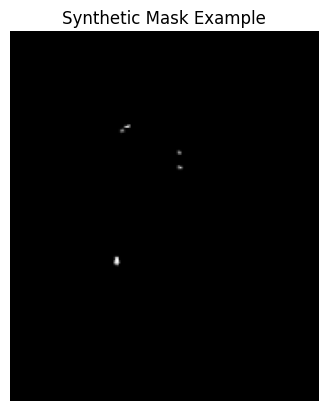

In [89]:
import os
import random
import numpy as np
import cv2
from scipy.ndimage import label
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def extract_lesions(mask):
    """Extract binary lesion components from a mask."""
    labeled, n = label(mask)
    lesions = []
    for i in range(1, n + 1):
        lesion = (labeled == i).astype(np.uint8) * 255
        if lesion.sum() > 0:
            lesions.append(lesion)
    return lesions

def transform_lesion(lesion, target_shape):
    """Randomly transform a lesion (rotate, scale)."""
    h, w = lesion.shape
    scale = random.uniform(0.8, 1.2)
    angle = random.uniform(-20, 20)
    lesion_resized = cv2.resize(lesion, None, fx=scale, fy=scale)
    M = cv2.getRotationMatrix2D((lesion_resized.shape[1] // 2, lesion_resized.shape[0] // 2), angle, 1)
    lesion_rotated = cv2.warpAffine(lesion_resized, M, (lesion_resized.shape[1], lesion_resized.shape[0]))

    # Ensure lesion fits target
    lh, lw = lesion_rotated.shape
    if lh >= target_shape[0] or lw >= target_shape[1]:
        return None
    return lesion_rotated

def paste_lesions(target_shape, lesion_list, max_lesions=5):
    """Paste transformed lesions into a blank mask."""
    new_mask = np.zeros(target_shape, dtype=np.uint8)
    attempts = 0
    while attempts < max_lesions:
        lesion = random.choice(lesion_list)
        lesion_transformed = transform_lesion(lesion, target_shape)
        if lesion_transformed is None:
            continue
        lh, lw = lesion_transformed.shape
        x_offset = random.randint(0, target_shape[0] - lh)
        y_offset = random.randint(0, target_shape[1] - lw)
        region = new_mask[x_offset:x_offset+lh, y_offset:y_offset+lw]
        new_mask[x_offset:x_offset+lh, y_offset:y_offset+lw] = np.maximum(region, lesion_transformed)
        attempts += 1
    return new_mask

def generate_synthetic_mask(source_mask_dir, slice_id, dataset, output_path):
    """Generate a synthetic lesion mask for a given slice using lesions from other brains."""
    lesion_bank = []
    for fname in os.listdir(source_mask_dir):
        if not fname.endswith(".png"):
            continue
        if dataset in fname and f"_{slice_id}.png" in fname:
            mask = np.array(Image.open(os.path.join(source_mask_dir, fname)).convert("L"))
            lesions = extract_lesions(mask)
            lesion_bank.extend(lesions)

    if len(lesion_bank) == 0:
        print(f"No lesion masks found for slice {slice_id} in {dataset}")
        return

    # Create new synthetic mask
    target_shape = lesion_bank[0].shape
    synthetic_mask = paste_lesions(target_shape, lesion_bank)

    # Save or visualize
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    Image.fromarray(synthetic_mask).save(output_path)

    # Also return for quick viewing here
    return synthetic_mask

# Example usage
source_mask_dir = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/mask"
example_output = generate_synthetic_mask(source_mask_dir, slice_id=1, dataset="WMH2017",
                                         output_path="./synthetic_masks/VH_slice5.png")

if example_output is not None:
    plt.imshow(example_output, cmap='gray')
    plt.title("Synthetic Mask Example")
    plt.axis('off')
    plt.show()


In [111]:
import os
import random
import numpy as np
import cv2
from scipy.ndimage import label
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt


def extract_lesions(mask):
    """Extract binary lesion components from a mask."""
    labeled, n = label(mask)
    lesions = []
    for i in range(1, n + 1):
        lesion = (labeled == i).astype(np.uint8) * 255
        area = np.sum(lesion > 0)
        lesions.append((lesion, area))
    return lesions


def categorize_lesions(lesions):
    """Divide lesions into small, medium, and large based on area."""
    areas = [a for _, a in lesions]
    if len(areas) < 3:
        return {'small': [], 'medium': [], 'large': []}

    # Use percentiles to divide
    small_th = np.percentile(areas, 33)
    large_th = np.percentile(areas, 66)

    categorized = {'small': [], 'medium': [], 'large': []}
    for lesion, area in lesions:
        if area <= small_th:
            categorized['small'].append(lesion)
        elif area <= large_th:
            categorized['medium'].append(lesion)
        else:
            categorized['large'].append(lesion)

    # print how many lesions in each category
    print(f"Small lesions: {len(categorized['small'])}")
    print(f"Medium lesions: {len(categorized['medium'])}")
    print(f"Large lesions: {len(categorized['large'])}")
    return categorized


def transform_lesion(lesion, target_shape, seed=None):
    """Randomly transform a lesion (rotate, scale)."""
    if seed is not None:
        random.seed(seed)

    scale = random.uniform(0.9, 1.1)
    angle = random.uniform(-15, 15)
    lesion_resized = cv2.resize(lesion, None, fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
    M = cv2.getRotationMatrix2D((lesion_resized.shape[1] // 2, lesion_resized.shape[0] // 2), angle, 1)
    lesion_rotated = cv2.warpAffine(lesion_resized, M, (lesion_resized.shape[1], lesion_resized.shape[0]), flags=cv2.INTER_NEAREST)

    # Ensure lesion fits target
    lh, lw = lesion_rotated.shape
    if lh >= target_shape[0] or lw >= target_shape[1]:
        return None
    return lesion_rotated


def paste_lesions(target_shape, lesion_dict, wm_mask, seed=None):
    """Paste one small, one medium, and one large lesion into a blank mask within WM/GM."""
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    new_mask = np.zeros(target_shape, dtype=np.uint8)
    categories = ['small', 'medium', 'large']

    for cat in categories:
        if not lesion_dict[cat]:
            continue

        tries = 0
        while tries < 20:
            lesion = random.choice(lesion_dict[cat])
            lesion_transformed = transform_lesion(lesion, target_shape, seed)
            if lesion_transformed is None:
                tries += 1
                continue

            lh, lw = lesion_transformed.shape
            x_offset = random.randint(0, target_shape[0] - lh)
            y_offset = random.randint(0, target_shape[1] - lw)

            # Check if target region in WM/GM mask
            region = wm_mask[x_offset:x_offset+lh, y_offset:y_offset+lw]
            if np.sum(region > 0) / (lh * lw) < 0.8:  # at least 80% must be WM/GM
                tries += 1
                continue

            new_mask[x_offset:x_offset+lh, y_offset:y_offset+lw] = np.maximum(
                new_mask[x_offset:x_offset+lh, y_offset:y_offset+lw], lesion_transformed)
            break

    return new_mask


def generate_synthetic_mask(source_mask_dir, slice_id, dataset, wm_mask_path, output_path, seed=42):
    """Generate a synthetic lesion mask for a given slice using other subjects' lesions."""
    lesion_bank = []
    for fname in os.listdir(source_mask_dir):
        if not fname.endswith(".png"):
            continue
        if dataset in fname and f"_{slice_id}.png" in fname:
            mask = np.array(Image.open(os.path.join(source_mask_dir, fname)).convert("L"))
            lesions = extract_lesions(mask)
            lesion_bank.extend(lesions)

    if len(lesion_bank) < 3:
        print(f"Not enough lesions for slice {slice_id} in {dataset}")
        return

    lesion_dict = categorize_lesions(lesion_bank)
    if not all(lesion_dict[cat] for cat in ['small', 'medium', 'large']):
        print(f"Missing categories for slice {slice_id} in {dataset}")
        return

    # Load WM/GM mask
    wm_mask = np.array(Image.open(wm_mask_path).convert("L"))
    target_shape = wm_mask.shape

    synthetic_mask = paste_lesions(target_shape, lesion_dict, wm_mask, seed=seed)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    Image.fromarray(synthetic_mask).save(output_path)

    return synthetic_mask


Small lesions: 24
Medium lesions: 23
Large lesions: 24


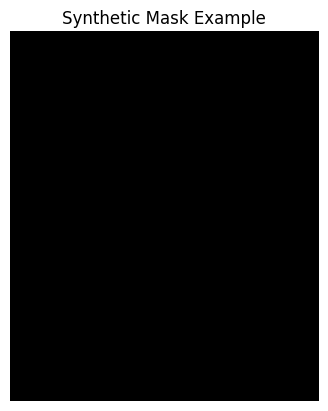

In [112]:
source_mask_dir = "/home/benet/data/lesion2D_VH-SHIFTS-WMH2017_empty_masks/test/mask"
wm_mask_path = "./test_images/WM_GM/VH_746_5.png"  # Example WM/GM mask
output_path = "./synthetic_masks/VH_slice5.png"

example_output= generate_synthetic_mask(
    source_mask_dir=source_mask_dir,
    slice_id=5,
    dataset="VH",
    wm_mask_path=wm_mask_path,
    output_path=output_path,
    # seed=17844  # reproducibility
)

if example_output is not None:
    plt.imshow(example_output, cmap='gray')
    plt.title("Synthetic Mask Example")
    plt.axis('off')
    plt.show()

